Improvement from the first submission:
- Preprocessing:
    - Missing data
        Air_temperature: fill with values from previous days
    - Timestamps alignment
    - Target variable : 
        - Remove outliers
        - Log1p transformation
- Feature engineering:
    - Study the correlation between variables

<a href='#1'>1. Data's Overview</a>

<a href='#2'>2. Preprocessing</a>

<a href='#3'>3. Feature engineering</a>

<a href='#4'>4. Simple model</a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import datetime # manipulating date formats

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


# <a id='1'>1. Data's Overview</a>

## Loading data

In [2]:
building_metadata = pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')
train = pd.read_csv('/kaggle/input/ashrae-energy-prediction/train.csv', parse_dates=['timestamp'])
test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv', parse_dates=['timestamp'])
weather_train = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv', parse_dates=['timestamp'])
weather_test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv', parse_dates=['timestamp'])

In [3]:
#Function to reduction memory usage (Source code from Kaggle)
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
building_metadata = reduce_mem_usage(building_metadata)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)

Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage after optimization is: 596.49 MB
Decreased by 53.1%
Memory usage after optimization is: 0.03 MB
Decreased by 60.3%
Memory usage after optimization is: 3.07 MB
Decreased by 68.1%
Memory usage after optimization is: 6.08 MB
Decreased by 68.1%


## Data's overview

In [5]:
print('Size of train data', train.shape)
print('Size of test data', test.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)
print('Size of building_metadata data', building_metadata.shape)

Size of train data (20216100, 4)
Size of test data (41697600, 4)
Size of weather_train data (139773, 9)
Size of weather_test data (277243, 9)
Size of building_metadata data (1449, 6)


In [6]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [7]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [8]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


Check missing data

In [9]:
def missing(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percentage = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])
    return missing_data.head(data.shape[1])

In [10]:
missing(weather_train)

,Total,Percentage
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
site_id,0,0.000000
timestamp,0,0.000000


In [11]:
missing(weather_test)

,Total,Percentage
cloud_coverage,140448,50.658808
precip_depth_1_hr,95588,34.478057
sea_level_pressure,21265,7.670167
wind_direction,12370,4.461790
wind_speed,460,0.165919
dew_temperature,327,0.117947
air_temperature,104,0.037512
site_id,0,0.000000
timestamp,0,0.000000


In [12]:
missing(building_metadata)

,Total,Percentage
floor_count,1094,75.500345
year_built,774,53.416149
site_id,0,0.000000
building_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000


# <a id='2'>2. Preprocessing</a>

## a. Missing data

### Air_temperature

There are only 55 missing values in the weather_train data set.

We fill the missing data with the value from the closest previous day without na, at the same time of the day, of the same site (there's no NA from the same hour in two consecutive days of the same site)

In [13]:
import math
def fill_air_temp(data):
    
    '''Function for filling Na data in air_temperature variable'''
    
    na_index = data[data['air_temperature'].isnull()].index
    temp_key = ['site_id', 'timestamp', 'air_temperature']
    
    for i in na_index:
        site_na = data.loc[i, 'site_id']   
        for j in range(5):
            time_na = data.loc[i,'timestamp'] - datetime.timedelta(days = j+1)  
            ind = data[(data.site_id == site_na) & (data.timestamp == time_na)].index  
            
            if math.isnan(data.loc[ind, 'air_temperature']) == False :
                data.loc[i, 'air_temperature'] = data.loc[ind, 'air_temperature'].values
                break
    
    return data

In [14]:
weather_train = fill_air_temp(weather_train)
weather_test = fill_air_temp(weather_test)

## b. Align the timestamp

The timestamps of the weather data and the train/test data are different: those in the weather data is not in the site's local time. So there's need an alignment before merging these dataset by timestamps.

To see this problem, we plot the air temperature (from weather data) and energy consumption (from train data) by site and hour.
We assume that highest air temperature should appear at around 14:00.

In [15]:
def plot_by_site_by_hour(data, column) :
    '''Plot a variable by site and hour'''
    
    plot_key = ['site_id', 'timestamp']
    col_to_plot = data[plot_key + [column]].copy()
    col_to_plot['hour'] = col_to_plot['timestamp'].dt.hour
    
    c = 1
    plt.figure(figsize=(25, 15))
    for site_id, data_by_site in col_to_plot.groupby('site_id'):
        by_site_by_hour = data_by_site.groupby('hour').mean()
        ax = plt.subplot(4, 4, c)
        plt.plot(by_site_by_hour.index,by_site_by_hour[column],'xb-')
        ax.set_title('site: '+str(site_id))
        c += 1
    return plt.show()

In [16]:
weather = pd.concat([weather_train,weather_test],ignore_index=True)

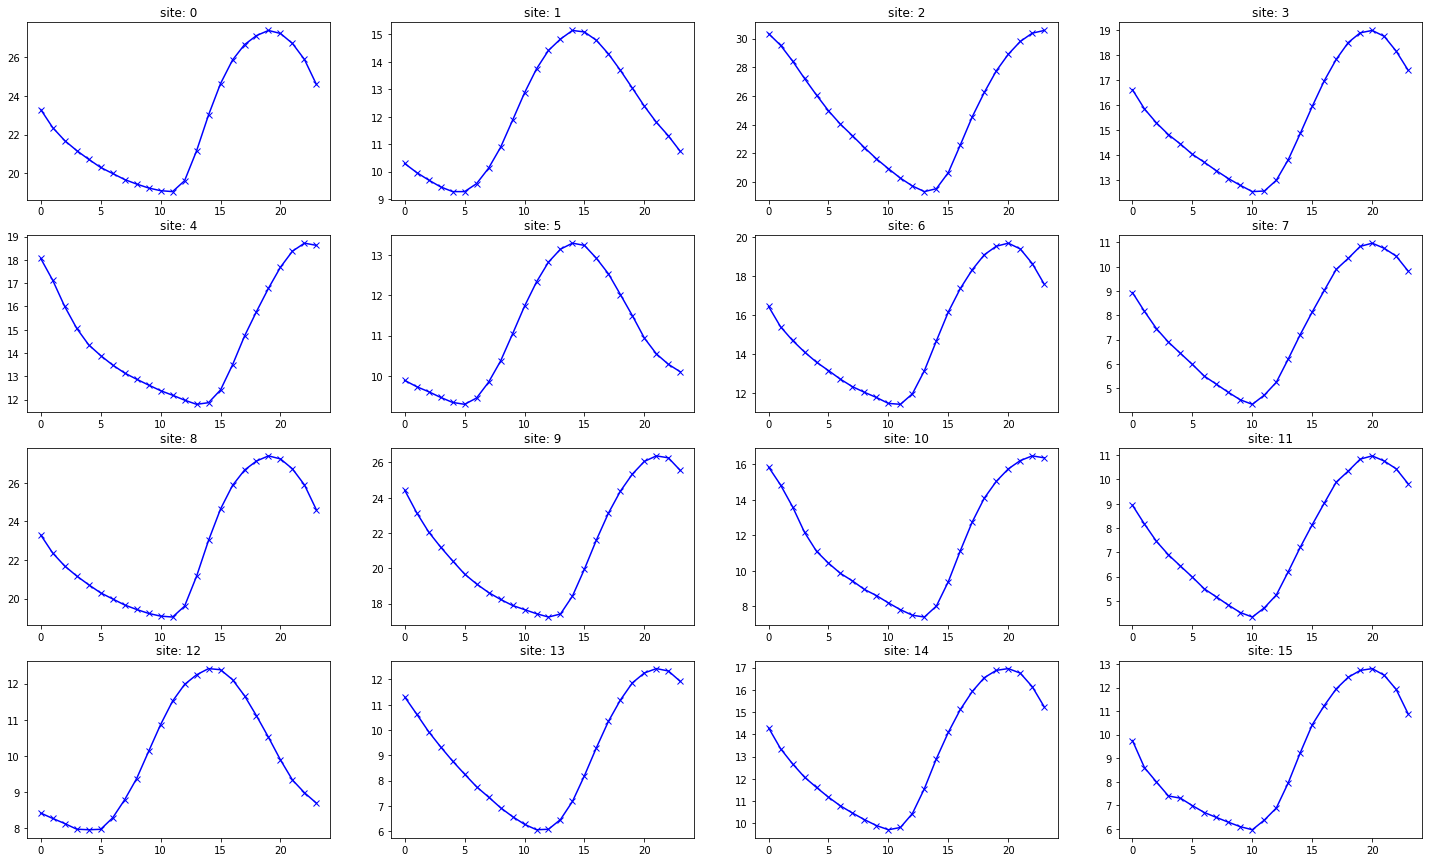

In [17]:
plot_by_site_by_hour(weather,'air_temperature')

We see that the peak temperature for most of these site are not around 14:00, some even at night, which doesn't make sense.

In [18]:
#Create dataframe having site_id and meter from train and metadata datasets
building_site_dict = dict(zip(building_metadata['building_id'], building_metadata['site_id']))
site_meter = train[['building_id', 'meter', 'timestamp', 'meter_reading']].copy()
site_meter['site_id'] = site_meter.building_id.map(building_site_dict)
del site_meter['building_id']

#Dataframe with site_id and electrical consumption
site_elec = site_meter[site_meter.meter == 0]

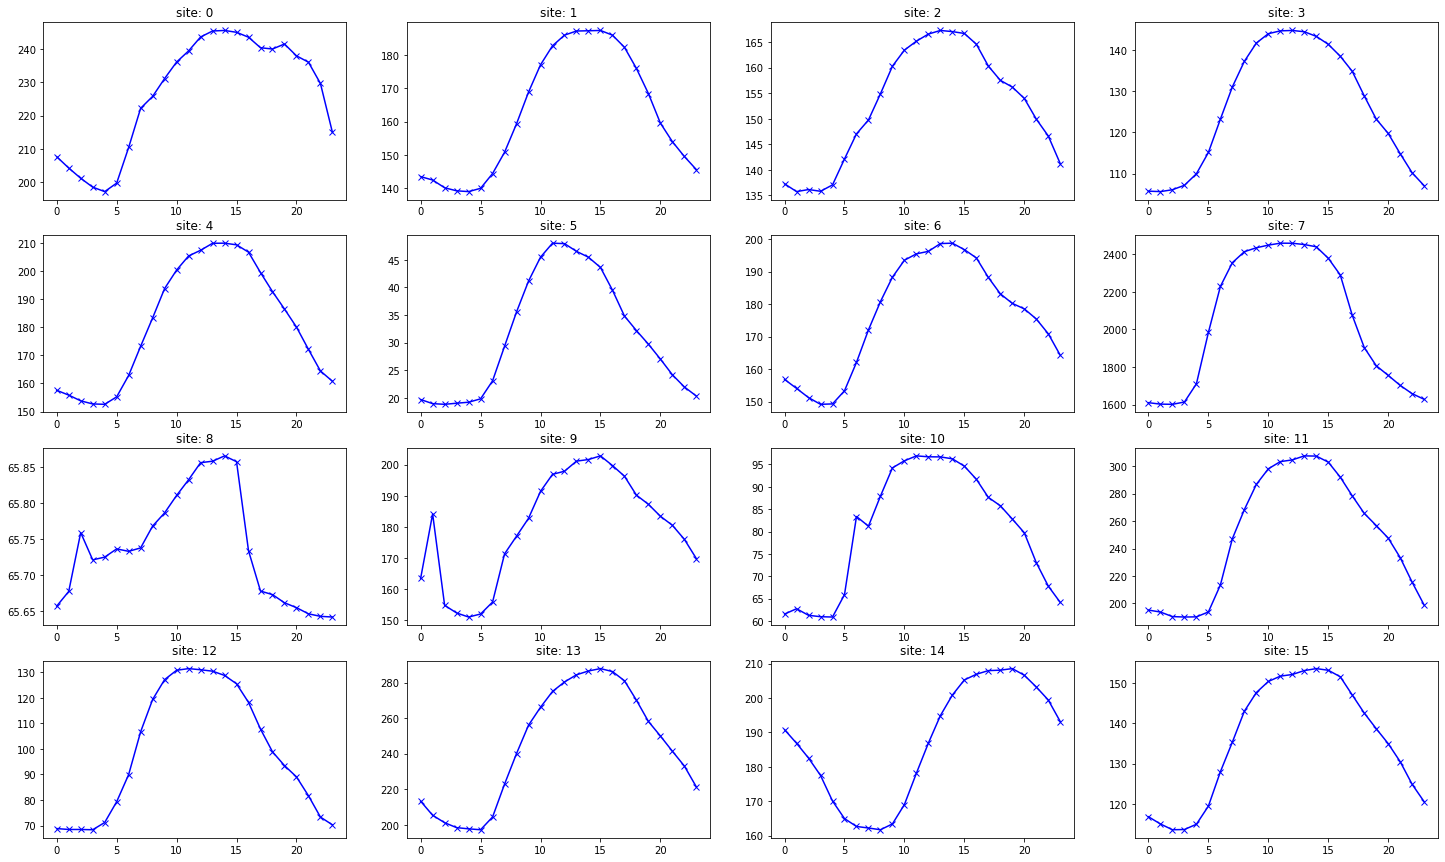

In [19]:
plot_by_site_by_hour(site_elec, 'meter_reading')
del building_site_dict, site_meter, site_elec

The energy consumption of these sites make sense, which mean that the timestamps are more aligned.

In [20]:
# calculate ranks of hourly temperatures within date and site_id
key = ['site_id', 'timestamp', 'air_temperature']
temp = weather.loc[:,key]
temp['temp_rank'] = temp.groupby(['site_id', temp.timestamp.dt.date])['air_temperature'].rank('average')
temp

# site_id x mean hour rank of temperature within day
mean_rank = temp.groupby(['site_id', temp.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)
temp

,site_id,timestamp,air_temperature,temp_rank
0,0,2016-01-01 00:00:00,25.000000,16.0
1,0,2016-01-01 01:00:00,24.406250,15.0
2,0,2016-01-01 02:00:00,22.796875,13.0
3,0,2016-01-01 03:00:00,21.093750,9.0
4,0,2016-01-01 04:00:00,20.000000,3.5
...,...,...,...,...
417011,15,2018-12-31 19:00:00,3.300781,23.5
417012,15,2018-12-31 20:00:00,2.800781,20.5
417013,15,2018-12-31 21:00:00,2.800781,20.5
417014,15,2018-12-31 22:00:00,2.800781,20.5


In [21]:
#the timestamp alignment gap for each site
gap = pd.Series(mean_rank.values.argmax(axis=1) - 14)
gap.index.name = 'site_id'

def timestamp_align(data):
    '''Function to align the timestamp'''
    data['offset'] = data.site_id.map(gap)
    data['timestamp_aligned'] = (data.timestamp - pd.to_timedelta(data.offset, unit='H'))
    data['timestamp'] = data['timestamp_aligned']
    del data['timestamp_aligned']
    return data

In [22]:
gap

site_id
0     5
1     0
2     9
3     6
4     8
5     0
6     6
7     6
8     5
9     7
10    8
11    6
12    0
13    7
14    6
15    6
dtype: int64

In [23]:
weather_train = timestamp_align(weather_train)
weather_test = timestamp_align(weather_test)

In [24]:
import gc
gc.collect()

80

## c. Merge data

In [25]:
train_merge = train.merge(building_metadata, on='building_id', how='left')
test_merge = test.merge(building_metadata, on='building_id', how='left')

train_merge = train_merge.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test_merge = test_merge.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [26]:
#del building_metadata, weather_train, weather_test, train, test
gc.collect()

40

## d. Create new variables

With the problem of the form of time series, we can create some useful variables. For example: year, month, date, hour, lagged variables. We will start with the simple ones: year, month, date, hour.

In [27]:
train_merge['month'] = train_merge['timestamp'].dt.month.astype(np.int8)
#train_merge['year'] = train_merge['timestamp'].dt.year.astype(np.int16)
train_merge['day'] = train_merge['timestamp'].dt.dayofweek.astype(np.int8)
train_merge['week'] = train_merge['timestamp'].dt.weekofyear.astype(np.int8)
train_merge['hour'] = train_merge['timestamp'].dt.hour.astype(np.int8)

test_merge['month'] = test_merge['timestamp'].dt.month.astype(np.int8)
#test_merge['year'] = test_merge['timestamp'].dt.year.astype(np.int16)
test_merge['day'] = test_merge['timestamp'].dt.dayofweek.astype(np.int8)
test_merge['week'] = test_merge['timestamp'].dt.weekofyear.astype(np.int8)
test_merge['hour'] = test_merge['timestamp'].dt.hour.astype(np.int8)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [28]:
gc.collect()

20

## e. Target variable and transformation

 Our original target variable is meter_reading.
 - Type 0 (electricity) of meter are mesure in kBTU. We need to convert them to kWh, and convert the prediction of this type again to kBTU before submission.
 - Transform the original target variable to obtain a new target variable *log1p(meter_reading)*

In [29]:
train_merge.loc[train_merge.meter == 0 , 'meter_reading'] = train_merge.loc[train_merge.meter == 0 , 'meter_reading'] * 0.2931

In [30]:
train_merge.meter_reading.describe()

count    2.021610e+07
mean     1.958269e+03
std      1.532163e+05
min      0.000000e+00
25%      6.353177e+00
50%      3.080891e+01
75%      1.383432e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

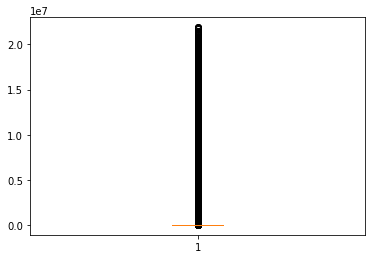

In [31]:
plt.boxplot(train_merge.meter_reading)
plt.show()

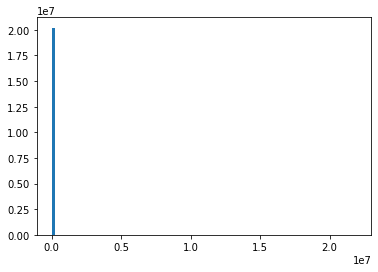

In [32]:
plt.hist(train_merge.meter_reading, bins = 100)
plt.show()

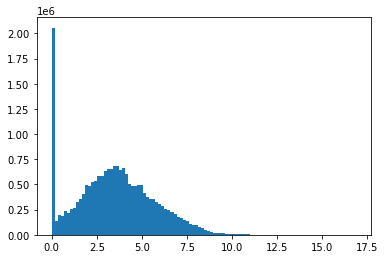

In [33]:
plt.hist(np.log1p(train_merge.meter_reading), bins = 100)
plt.show()

### Identify Outliers

In [34]:
#train_merge['m/s'] = train_merge['meter_reading']/train_merge['square_feet']

In [35]:
#elec_ms = train_merge[(train_merge.meter==0) & (train_merge.meter_reading > 0)].loc[:,'m/s']

In [36]:
#elec_ms.describe()

### Create new target variable

In [37]:
train_merge['target'] = np.log1p(train_merge['meter_reading'])

In [38]:
train_0 = train_merge[train_merge.target > 0]
Q1 = train_0.target.quantile(0.25)
Q3 = train_0.target.quantile(0.75)
IQR = Q3 - Q1
del train_0
gc.collect()
train_merge = train_merge[train_merge.target <= Q3 + 1.5 * IQR]

In [39]:
train_merge.shape

(20106994, 22)

# <a id='3'>3. Feature Engineering</a>

Correlation between target variable and other variable

In [40]:
#corr = train_merge.corr()

In [41]:
#plt.subplots(figsize=(20, 20))
#sns.heatmap(corr, annot = True, mask = np.triu(corr))

# <a id='4'>4. Simple model</a>

In [42]:
from sklearn.tree import DecisionTreeRegressor

y_train = train_merge['target']
x_train = train_merge.dropna(axis = 1)
#del train_IQR, train_merge
gc.collect()

x = pd.get_dummies(x_train[['primary_use']],drop_first=True)
x_train = pd.concat([x_train, x], axis = 1)
x_train = x_train.drop(['primary_use','meter_reading','target', 'timestamp'], axis = 1)

x = pd.get_dummies(test_merge[['primary_use']],drop_first=True)
x_test = pd.concat([test_merge, x], axis = 1)
x_test = x_test.drop(['primary_use', 'timestamp'], axis = 1)
x_test = x_test.dropna(axis = 1)
x_test = x_test.drop('row_id', axis = 1)

In [43]:
tree_model = DecisionTreeRegressor(min_samples_split = 200, min_samples_leaf = 100)
tree_model = tree_model.fit(x_train, y_train)

In [44]:
y_pred = np.exp(tree_model.predict(x_test))-1
y_pred[x_test.meter==0] = y_pred[x_test.meter==0] / 0.2931

In [45]:
my_submission = pd.DataFrame({'row_id': test_merge.row_id, 'meter_reading': y_pred})
my_submission.to_csv('first_submission.csv', index=False, compression='gzip')